In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
from torchvision.datasets import ImageFolder
import numpy as np

In [22]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [23]:
# To check if GPU is available
print(torch.cuda.is_available())
# To check the CUDA version
print(torch.version.cuda)

True
12.6


In [24]:
import os
from PIL import Image
from torch.utils.data import Dataset

class GalaxyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_name)
        
        # Extract the class label correctly (get the part before '.png' or any extension)
        label_str = img_name.split('_')[-1].split('.')[0]
        try:
            label = int(label_str)
        except ValueError:
            print(f"Error converting label: {label_str}")
            raise
        
        # Load image
        image = Image.open(img_path).convert("RGB")
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label

# **Correcting the path to dataset**
data_dir = os.path.expanduser("~/Desktop/BE Project/Decals_data_images")  # Ensure correct dataset path

# Your training and evaluation code would follow here


In [25]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [26]:
dataset = GalaxyDataset(root_dir=data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [27]:
class GalaxyCNN(nn.Module):
    def __init__(self, num_classes):
        super(GalaxyCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 8 * 8, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [28]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [29]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            progress_bar.set_postfix({
                'loss': running_loss/len(train_loader),
                'accuracy': 100.*correct/total
            })

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100. * correct / total
        
        val_loss, val_accuracy = evaluate_model(model, val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        scheduler.step(val_loss)
        
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    plot_curves(train_losses, val_losses, train_accuracies, val_accuracies)

def evaluate_model(model, loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    accuracy = 100. * correct / total
    loss = running_loss / len(loader)
    print(f'Accuracy: {accuracy:.2f}%, Loss: {loss:.4f}')
    return loss, accuracy

def plot_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r', label='Training loss')
    plt.plot(epochs, val_losses, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()


Evaluating: 100%|██████████| 89/89 [00:11<00:00,  7.90it/s]


Accuracy: 28.79%, Loss: 1.8539


Evaluating: 100%|██████████| 89/89 [00:10<00:00,  8.20it/s]


Accuracy: 45.70%, Loss: 1.4327


Evaluating: 100%|██████████| 89/89 [00:15<00:00,  5.84it/s]


Accuracy: 54.16%, Loss: 1.2884


Evaluating: 100%|██████████| 89/89 [00:16<00:00,  5.36it/s]


Accuracy: 56.66%, Loss: 1.1927


Evaluating: 100%|██████████| 89/89 [00:10<00:00,  8.13it/s]


Accuracy: 58.81%, Loss: 1.1695


Evaluating: 100%|██████████| 89/89 [00:10<00:00,  8.33it/s]


Accuracy: 60.29%, Loss: 1.1230


Evaluating: 100%|██████████| 89/89 [00:11<00:00,  7.86it/s]


Accuracy: 62.40%, Loss: 1.0909


Evaluating: 100%|██████████| 89/89 [00:16<00:00,  5.47it/s]


Accuracy: 66.42%, Loss: 1.0151


Evaluating: 100%|██████████| 89/89 [00:17<00:00,  4.97it/s]


Accuracy: 64.94%, Loss: 1.1761


Evaluating: 100%|██████████| 89/89 [00:16<00:00,  5.38it/s]


Accuracy: 65.86%, Loss: 1.2118


Evaluating: 100%|██████████| 89/89 [00:17<00:00,  4.97it/s]


Accuracy: 61.98%, Loss: 1.3163


Evaluating: 100%|██████████| 89/89 [00:11<00:00,  8.05it/s]


Accuracy: 63.18%, Loss: 1.4019


Evaluating: 100%|██████████| 89/89 [00:10<00:00,  8.20it/s]


Accuracy: 64.09%, Loss: 1.5280


Evaluating: 100%|██████████| 89/89 [00:10<00:00,  8.20it/s]


Accuracy: 64.31%, Loss: 1.5442


Evaluating: 100%|██████████| 89/89 [00:10<00:00,  8.23it/s]


Accuracy: 61.98%, Loss: 1.9942


Evaluating: 100%|██████████| 89/89 [00:10<00:00,  8.29it/s]


Accuracy: 61.63%, Loss: 1.9572


Evaluating: 100%|██████████| 89/89 [00:11<00:00,  8.09it/s]


Accuracy: 64.16%, Loss: 1.9973


Evaluating: 100%|██████████| 89/89 [00:10<00:00,  8.15it/s]


Accuracy: 61.10%, Loss: 1.9671
Early stopping


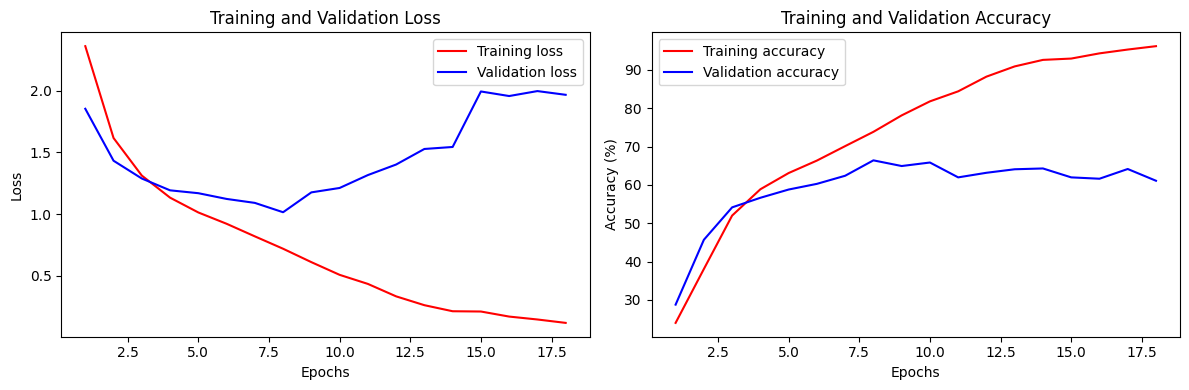

Evaluating: 100%|██████████| 111/111 [00:15<00:00,  7.19it/s]


Accuracy: 62.37%, Loss: 1.9323
Model saved successfully!


In [30]:
# Split training set into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GalaxyCNN(num_classes=10).to(device)

# Define loss function, optimizer, scheduler, and early stopping
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
early_stopping = EarlyStopping(patience=10, verbose=True)

# Number of epochs
num_epochs = 20

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, num_epochs)

# Evaluate the model
evaluate_model(model, test_loader)

# Save the trained model
torch.save(model.state_dict(), "galaxy_cnn.pth")
print("Model saved successfully!")

Precision: 0.6298
Recall: 0.6237
Confusion Matrix:
[[ 34  18  24  25   2  15  14  51   6   4]
 [  8 235   9  23   5  17   9  16   4  12]
 [ 17  23 426  11   0   8  44  13   0   1]
 [ 17  19  12 309   6  15   7  17   0  12]
 [  4   5   0  10  32   0   2   3   0  15]
 [ 12   8   8  10   4 242  81  44   2   9]
 [ 14   6   9   2   1  28 203  74   4   4]
 [ 46  26  12  24   2  63 143 222   7  14]
 [  7  17   0   0   2   0   4   7 212  40]
 [  7  19   1  19   6   4   1   2  19 298]]


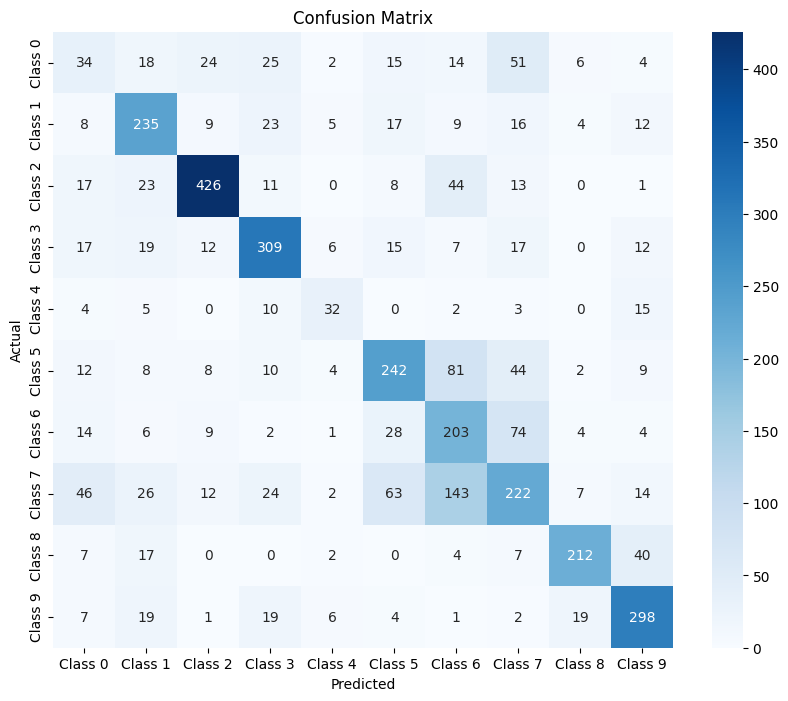

In [32]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate model on the test set
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate precision and recall
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

# Plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Class names (assuming you have 10 classes, update if different)
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9']

# Call the plotting function
plot_confusion_matrix(conf_matrix, class_names)
